In [82]:
# Base library imports
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt

# SolNet imports
from src.data.datafetcher import PvFetcher
from src.data.featurisation import Featurisation
from src.tensors.tensorisation import Tensors
from src.models.lstm import LSTM
from src.models.training import Training
from src.models.training import save_model
from src.evaluation.evaluation import Evaluation
from src.util.open_meteo_api import Open_meteo

# Specify the parameters

In [83]:
# Hyperparameters needed for a run:

# Data fetching
latitude = 52.30864 # °
longitude = 4.88959 # °
azimuth = None
tilt = None
optimal_angles = 1
peak_power = 2.48 # kWp

# Forecasting parameters
target = 'P'
past_features = ['P']
future_features = ['hour_sin','hour_cos','relative_humidity_2m','diffuse_radiation', 'direct_radiation']
weather_features = True
open_meteo_variables = ['relative_humidity_2m','diffuse_radiation', 'direct_radiation']
lags = 24
forecast_period = 24
gap = 0 
forecast_gap = 0

# Lstm parameters
hidden_size = 200
num_layers = 3
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
epochs = 100
batch_size = 32
learning_rate = 0.001

# Model
model_name = 'Amstelveen'

# Gather data

In [84]:
# Fetch data from PVGIS
data_PVGIS = PvFetcher(latitude,longitude,peak_power, tilt, azimuth,optimal_angles=optimal_angles)
# We take the location we want from our list
data = [data_PVGIS.dataset[0]]

Gathering data from base location...


In [85]:
# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
dataset = Featurisation(data).base_features(past_features)

# Use cyclic features as well
dataset = Featurisation(dataset).cyclic_features(yearly=False)
features = dataset[0].columns # update the features
source_data = dataset[0].copy()

In [86]:
if weather_features is True:
    
    start = dataset[0].index[0].date()
    end = dataset[0].index[-1].date()
    weather_fetcher = Open_meteo(latitude, longitude, open_meteo_variables, start, end)
    
    weather_data = weather_fetcher.get_open_meteo_hourly()
    weather_data.set_index('date', inplace=True)
    weather_data = weather_data.tz_localize(None)
    
    source_data = pd.concat([dataset[0], weather_data], axis=1)
    source_data = source_data.loc[start:end]

Coordinates 52.337432861328125°N 4.833333492279053°E
Elevation -4.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [87]:
source_data.head()

,P,hour_sin,hour_cos,relative_humidity_2m,diffuse_radiation,direct_radiation
2005-01-01 00:00:00,0.000,0.000,1.000,88.571,0.000,0.000
2005-01-01 01:00:00,0.000,0.259,0.966,87.027,0.000,0.000
2005-01-01 02:00:00,0.000,0.500,0.866,85.504,0.000,0.000
2005-01-01 03:00:00,0.000,0.707,0.707,84.596,0.000,0.000
2005-01-01 04:00:00,0.000,0.866,0.500,84.567,0.000,0.000


# Transform the data into tensors

In [88]:
# Get the data in the torch.tensor format
src_tensors = Tensors(source_data, 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap)

# Split the data into train and test sets with separate tensors for features (X) and the target (y)
X_train_src, X_test_src, y_train_src, y_test_src = src_tensors.create_tensor()
X_train_src.shape, X_test_src.shape, y_train_src.shape, y_test_src.shape

(torch.Size([4674, 24, 6]),
 torch.Size([1168, 24, 6]),
 torch.Size([4674, 24]),
 torch.Size([1168, 24]))

# Create and train a source model

In [89]:
# Set the parameters for the lstm
input_size = len(past_features + future_features)

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(6, 200, num_layers=3, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=200, out_features=24, bias=True)
)

Step 0: Average train loss: 0.0230 | Average test loss: 0.0162
Step 5: Average train loss: 0.0110 | Average test loss: 0.0090
Step 10: Average train loss: 0.0102 | Average test loss: 0.0084
Step 15: Average train loss: 0.0099 | Average test loss: 0.0081
Step 20: Average train loss: 0.0095 | Average test loss: 0.0081
Step 25: Average train loss: 0.0094 | Average test loss: 0.0081
Step 30: Average train loss: 0.0091 | Average test loss: 0.0080
Step 35: Average train loss: 0.0090 | Average test loss: 0.0081
Step 40: Average train loss: 0.0090 | Average test loss: 0.0080
Step 45: Average train loss: 0.0089 | Average test loss: 0.0078
Step 50: Average train loss: 0.0089 | Average test loss: 0.0078
Step 55: Average train loss: 0.0089 | Average test loss: 0.0082
Step 60: Average train loss: 0.0088 | Average test loss: 0.0077
Step 65: Average train loss: 0.0087 | Average test loss: 0.0077
Step 70: Average train loss: 0.0086 | Average test loss: 0.0078
Step 75: Average train loss: 0.0086 | Aver

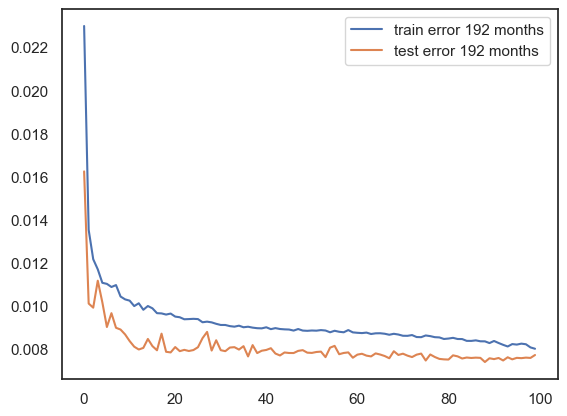

In [90]:
# Initialize the trainer
training = Training(my_lstm, X_train_src, y_train_src, X_test_src, y_test_src, epochs,batch_size=batch_size, learning_rate=learning_rate)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit(verbose=True)

In [91]:
# Load the state dictionary of the best performing model
my_lstm.load_state_dict(state_dict_list[best_epoch])

# Save the model state dictionary for later use 
save_model(my_lstm, 'SolNet/' + model_name)

In [92]:
# Forecast with the model
forecasts = my_lstm(X_test_src.to(device))

# Evaluate the model performance
source_eval = Evaluation(y_test_src.detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

In [112]:
source_eval.metrics()[source_eval.metrics().columns[:3]]

,RMSE,MBE,MAE
Metrics,0.155,0.009,0.089


<Figure size 700x700 with 0 Axes>

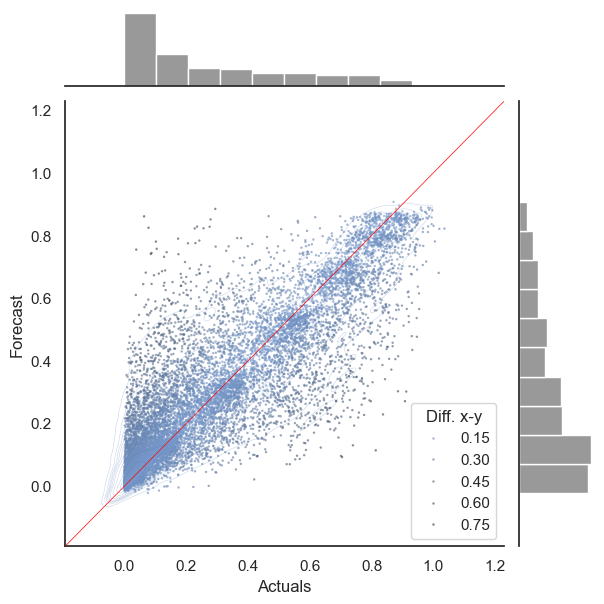

In [94]:
source_eval.plot_joint(levels=10, no_zero=True)

# Optional: Transfer learning

## Fetch your own data

### ! This data is not publicly available and only serves as a template. The user should plug in their own data in this section.

In [95]:
system_id = 0
# Get the list of ID codes
id_list = pd.read_csv('../data/netherlands/id_list.csv',header=None)

# We need the meta-data for the source location
meta_data_nl = pd.read_csv('../data/netherlands/installations Netherlands.csv', delimiter=';')

# Decide on the location
installation = meta_data_nl.index[meta_data_nl['id'] == id_list.loc[system_id].values[0]][0]
site_id = meta_data_nl.iloc[installation]['id']

In [96]:
data_nl = pd.read_parquet('../data/netherlands/production.parquet', engine='pyarrow')
data_nl = data_nl.loc[site_id]
data_nl = data_nl.resample('H').mean()
data_nl = data_nl.rename(columns={"watt":"P"})

# Avoid data leakage for this example
first_index = data_nl[(data_nl.index.hour == 0) & (data_nl.index.day == 1) & (data_nl.index.month == 1) & (data_nl.index.year == 2020)].index[0]

target_data = data_nl.loc[first_index:]

In [97]:
target_data.head()

,P
timestamp,
2020-01-01 00:00:00,0.000
2020-01-01 01:00:00,0.000
2020-01-01 02:00:00,0.000
2020-01-01 03:00:00,0.000
2020-01-01 04:00:00,0.000


## Featurise the data

In [98]:
target_featurisation = Featurisation([target_data])
target_data = target_featurisation.cyclic_features(yearly=False)[0]

In [99]:
if weather_features is True:
    
    start = target_data.index[0].date()
    end = target_data.index[-1].date()
    weather_fetcher = Open_meteo(latitude, longitude, open_meteo_variables, start, end)
    
    weather_data = weather_fetcher.get_open_meteo_hourly()
    weather_data.set_index('date', inplace=True)
    weather_data = weather_data.tz_localize(None)
    
    target_data = pd.concat([target_data, weather_data], axis=1)
    target_data = target_data.loc[start:end]

Coordinates 52.337432861328125°N 4.833333492279053°E
Elevation -4.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


## Create tensors

In [100]:
# Get the data in the torch.tensor format
target_tensors = Tensors(target_data, 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap)

# Split the data into train and test sets with separate tensors for features (X) and the target (y)
X_train, X_test, y_train, y_test = target_tensors.create_tensor()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([468, 24, 6]),
 torch.Size([117, 24, 6]),
 torch.Size([468, 24]),
 torch.Size([117, 24]))

## Create a transfer model

In [101]:
# Create a transfer model
transfer_model  = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)

# Load the state dictionary from the source model into the transfer model 
transfer_model.load_state_dict(torch.load('../models/SolNet/' + model_name))

<All keys matched successfully>

## Train / Finetune the transfer model

In [102]:
for name, _ in transfer_model.lstm.named_parameters():
    print(name)

weight_ih_l0
weight_hh_l0
bias_ih_l0
bias_hh_l0
weight_ih_l1
weight_hh_l1
bias_ih_l1
bias_hh_l1
weight_ih_l2
weight_hh_l2
bias_ih_l2
bias_hh_l2


In [103]:
# Layers to freeze
freezing = []

for name, _ in my_lstm.lstm.named_parameters():
    freezing.append(name)
    
freezing = freezing[:4]
freezing

['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0']

In [104]:
# Specify that the frozen weights and biases do not require training
for name, param in transfer_model.lstm.named_parameters():
    if any(freezing_name in name for freezing_name in freezing):
        param.requires_grad = False

In [105]:
# initialize the trainer
training = Training(transfer_model, 
                    X_train, 
                    y_train, 
                    X_test, 
                    y_test, 
                    epochs=50, batch_size = batch_size, learning_rate =learning_rate/10)

Step 0: Average train loss: 0.0157 | Average test loss: 0.0221
Step 5: Average train loss: 0.0113 | Average test loss: 0.0170
Step 10: Average train loss: 0.0087 | Average test loss: 0.0140
Step 15: Average train loss: 0.0067 | Average test loss: 0.0112
Step 20: Average train loss: 0.0057 | Average test loss: 0.0098
Step 25: Average train loss: 0.0052 | Average test loss: 0.0097
Step 30: Average train loss: 0.0048 | Average test loss: 0.0096
Step 35: Average train loss: 0.0046 | Average test loss: 0.0096
Step 40: Average train loss: 0.0043 | Average test loss: 0.0095
Step 45: Average train loss: 0.0043 | Average test loss: 0.0096
Best Epoch: 39


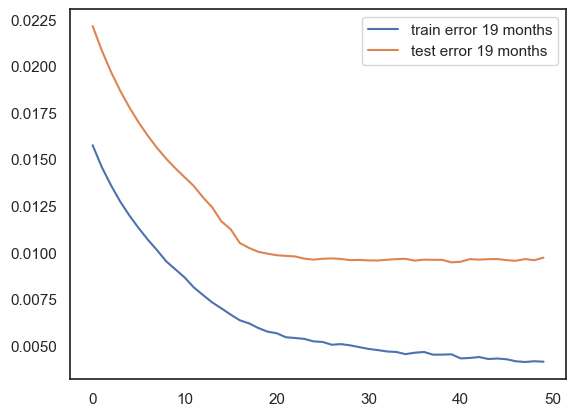

In [106]:
# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit(verbose=True)

In [107]:
# Load the best performing model
transfer_model.load_state_dict(state_dict_list[best_epoch])

<All keys matched successfully>

In [108]:
# Forecast with the source model
forecasts_source = my_lstm(X_test.to(device))
forecasts_transfer = transfer_model(X_test.to(device))

# Evaluate the model performance
source_eval = Evaluation(y_test.detach().flatten().numpy(), forecasts_source.cpu().detach().flatten().numpy())
target_eval = Evaluation(y_test.detach().flatten().numpy(), forecasts_transfer.cpu().detach().flatten().numpy())

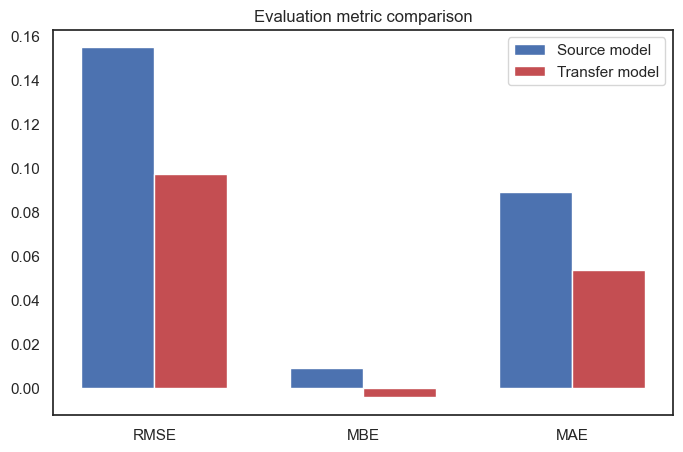

In [109]:
# Extract the first 3 columns
cols_to_plot = source_eval.metrics().columns[:3]
df1_values = source_eval.metrics()[cols_to_plot].values.flatten()
df2_values = target_eval.metrics()[cols_to_plot].values.flatten()

# Define bar width and positions
x = np.arange(len(cols_to_plot))  # X locations for clusters
bar_width = 0.35  

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - bar_width/2, df1_values, bar_width, label='Source model', color='b')
ax.bar(x + bar_width/2, df2_values, bar_width, label='Transfer model', color='r')

# Labels and Formatting
ax.set_xticks(x)
ax.set_xticklabels(cols_to_plot)
ax.set_title("Evaluation metric comparison")
ax.legend()

# Show plot
plt.show()